In [5]:
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.utils import plot_model
from keras.optimizers import Adam,SGD
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K

from glob import glob
from matplotlib import pyplot as plt
from numpy.linalg import inv
import cv2
import random
import numpy as np
import time

## HomographyNet Model Architecture

![alt text](./documentation_images/homographynet.png "General HomogrophyNet Model Architecture")

## HomographyNet as reported in the paper has two different variants.

1. The classification head model variant
2. The regression head model variant

![alt text](./documentation_images/twoheads.png "HomogrophyNet Model Variants")

### The version we are going to implement is the Regression head variant!

In [6]:
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.maximum(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True), K.epsilon()))

def homography_regression_model():
    input_shape=(128, 128, 2)
    input_img = Input(shape=input_shape)
     
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv1")(input_img)
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
    
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv3")(x)
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv4")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
   
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv5")(x)
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv6")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
    
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv7")(x)
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv8")(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75, noise_shape=None, seed=None)(x)
    x = Dense(1024, name='FC1')(x)
    out = Dense(8, name='loss')(x)
    
    model = Model(inputs=input_img, outputs=[out])
    plot_model(model, to_file='documentation_images/HomegraphyNet_Regression.png', show_shapes=True)
    
    model.compile(optimizer=Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=euclidean_distance)
    return model

In [7]:
#visualizing the model
model = homography_regression_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 2)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1216      
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 64)        36928     
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 64, 64)        36928     
__________

In [17]:
# function for training and test
def get_train(path = "./ms_coco_test_images/*.jpg", num_examples = 1280):
    # hyperparameters
    rho = 32
    patch_size = 128
    height = 240
    width = 320

    loc_list = glob(path)
    X = np.zeros((num_examples,128, 128, 2))  # images
    Y = np.zeros((num_examples,8))
    for i in range(num_examples):
        # select random image from tiny training set
        index = random.randint(0, len(loc_list)-1)
        img_file_location = loc_list[index]
        color_image = plt.imread(img_file_location)
        color_image = cv2.resize(color_image, (width, height))
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

        # create random point P within appropriate bounds
        y = random.randint(rho, height - rho - patch_size)  # row?
        x = random.randint(rho, width - rho - patch_size)  # col?
        # define corners of image patch
        top_left_point = (x, y)
        bottom_left_point = (patch_size + x, y)
        bottom_right_point = (patch_size + x, patch_size + y)
        top_right_point = (x, patch_size + y)
        four_points = [top_left_point, bottom_left_point, bottom_right_point, top_right_point]
        perturbed_four_points = []
        for point in four_points:
            perturbed_four_points.append((point[0] + random.randint(-rho, rho), point[1] + random.randint(-rho, rho)))

        # compute H
        H = cv2.getPerspectiveTransform(np.float32(four_points), np.float32(perturbed_four_points))
        H_inverse = inv(H)
        inv_warped_image = cv2.warpPerspective(gray_image, H_inverse, (320, 240))
        warped_image = cv2.warpPerspective(gray_image, H, (320, 240))

        # grab image patches
        original_patch = gray_image[y:y + patch_size, x:x + patch_size]
        warped_patch = inv_warped_image[y:y + patch_size, x:x + patch_size]
        # make into dataset
        training_image = np.dstack((original_patch, warped_patch))
        H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
        X[i, :, :] = training_image
        Y[i, :] = H_four_points.reshape(-1)        
    return X,Y

def get_generator(path = "./ms_coco_test_images/*.jpg", num_examples = 256):
    while 1:
        # hyperparameters
        rho = 32
        patch_size = 128
        height = 240
        width = 320

        loc_list = glob(path)
        X = np.zeros((num_examples,128, 128, 2))  # images
        Y = np.zeros((num_examples,8))
        for i in range(num_examples):
            # select random image from tiny training set
            index = random.randint(0, len(loc_list)-1)
            img_file_location = loc_list[index]
            color_image = plt.imread(img_file_location)
            color_image = cv2.resize(color_image, (width, height))
            gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

            # create random point P within appropriate bounds
            y = random.randint(rho, height - rho - patch_size)  # row
            x = random.randint(rho, width - rho - patch_size)  # col
            # define corners of image patch
            top_left_point = (x, y)
            bottom_left_point = (patch_size + x, y)
            bottom_right_point = (patch_size + x, patch_size + y)
            top_right_point = (x, patch_size + y)
            four_points = [top_left_point, bottom_left_point, bottom_right_point, top_right_point]
            perturbed_four_points = []
            for point in four_points:
                perturbed_four_points.append((point[0] + random.randint(-rho, rho), point[1] + random.randint(-rho, rho)))

            # compute H
            H = cv2.getPerspectiveTransform(np.float32(four_points), np.float32(perturbed_four_points))
            H_inverse = inv(H)
            inv_warped_image = cv2.warpPerspective(gray_image, H_inverse, (320, 240))
            warped_image = cv2.warpPerspective(gray_image, H, (320, 240))

            # grab image patches
            original_patch = gray_image[y:y + patch_size, x:x + patch_size]
            warped_patch = inv_warped_image[y:y + patch_size, x:x + patch_size]
            # make into dataset
            training_image = np.dstack((original_patch, warped_patch))
            H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
            X[i, :, :] = training_image
            Y[i, :] = H_four_points.reshape(-1)        
        yield (X,Y)

def get_test(path):
    rho = 32
    patch_size = 128
    height = 240
    width = 320
    #random read image
    loc_list = glob(path)
    index = random.randint(0, len(loc_list)-1)
    img_file_location = loc_list[index]
    color_image = plt.imread(img_file_location)
    color_image = cv2.resize(color_image,(width,height))
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
    #points
    y = random.randint(rho, height - rho - patch_size)  # row
    x = random.randint(rho,  width - rho - patch_size)  # col
    top_left_point = (x, y)
    bottom_left_point = (patch_size + x, y)
    bottom_right_point = (patch_size + x, patch_size + y)
    top_right_point = (x, patch_size + y)
    four_points = [top_left_point, bottom_left_point, bottom_right_point, top_right_point]
    four_points_array = np.array(four_points)
    perturbed_four_points = []
    for point in four_points:
        perturbed_four_points.append((point[0] + random.randint(-rho, rho), point[1] + random.randint(-rho, rho)))
        
    #compute H
    H = cv2.getPerspectiveTransform(np.float32(four_points), np.float32(perturbed_four_points))
    H_inverse = inv(H)
    inv_warped_image = cv2.warpPerspective(gray_image, H_inverse, (width, height))
    # grab image patches
    original_patch = gray_image[y:y + patch_size, x:x + patch_size]
    warped_patch = inv_warped_image[y:y + patch_size, x:x + patch_size]
    # make into dataset
    training_image = np.dstack((original_patch, warped_patch))
    val_image = training_image.reshape((1,128,128,2))
    
    return color_image, H_inverse,val_image,four_points_array

In [11]:
#voc image train 

# method1: the training is after getting data. this method is very slow
'''
train_number = 200
t0 = time.time()
for i in range(train_number):
    t1 = time.time()
    train_images,train_labels = get_train(path = "./test_images/*.jpg", num_examples = 1280)      
    model = homography_regression_model()
    print "loading model weights"
    model.load_weights('my_model_weights.h5')
    print "training ......"
    model.fit(train_images,train_labels,epochs=1, batch_size=64)
    print "saving model weights"
    model.save_weights('my_model_weights.h5')
    K.clear_session()
    t2 = time.time()
    print "training_number:"+str(i)+"   spend time:"+str(t2-t1)+"s" + "    total time:" + str(t2-t0)+"s"  
'''
#method2: We use python generator method to generating data. training and getting data are simultaneous. It's faster.
#You can change steps_per_epoch value to adjust the total training step 
K.clear_session()
model = homography_regression_model()
t0 = time.time()
print "loading model weights"
model.load_weights('my_model_weights.h5')
print "training ......"
model.fit_generator(get_generator(path = "./test_images/*.jpg",num_examples=64),epochs=1, steps_per_epoch=5)
print "saving model weights"
model.save_weights('my_model_weights.h5')
K.clear_session()
t1 = time.time()
print   "spend total time:"+str(t1-t0)+"s" 

loading model weights
training ......
Epoch 1/1
5/5 [==============================] - 2s - loss: 17.0481     
saving model weights
spend total time:4.1790599823s


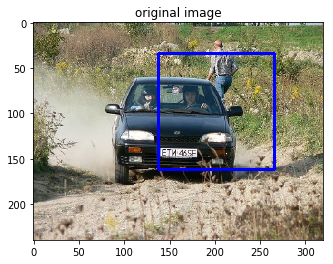

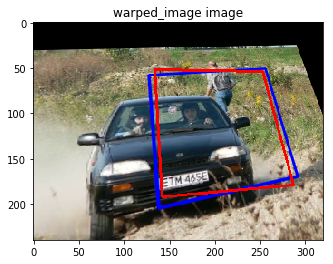

In [15]:
#voc image test 
K.clear_session()
model = homography_regression_model()
model.load_weights('my_model_weights.h5')

color_image, H_matrix,val_image,four_points_array = get_test("./test_images/*.jpg")
four_points_array_ = four_points_array.reshape((1,4,2))
rectangle_image = cv2.polylines(color_image, four_points_array_, 1, (0,0,255),2)
warped_image = cv2.warpPerspective(rectangle_image, H_matrix, (color_image.shape[1], color_image.shape[0]))
labels = model.predict(val_image)
K.clear_session()
labels_ = np.int32(labels.reshape((4,2)))
perturbed_four = np.subtract(four_points_array,labels_)
perturbed_four_ = perturbed_four.reshape((1,4,2))
warped_image = cv2.polylines(warped_image, perturbed_four_, 1, (255,0,0),2)
 
plt.imshow(rectangle_image) 
plt.title('original image')  
plt.show()

plt.imshow(warped_image) 
plt.title('warped_image image')
plt.show()